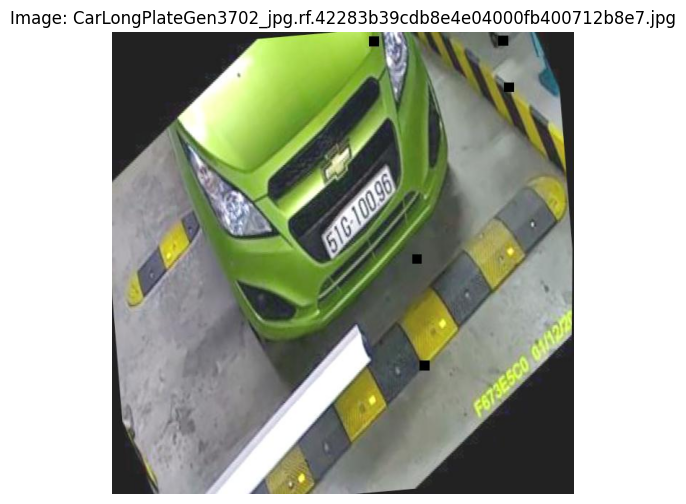

Image path: /kaggle/input/cv-project-dataset/train/images/CarLongPlateGen3702_jpg.rf.42283b39cdb8e4e04000fb400712b8e7.jpg
Image shape: (640, 640, 3)
-------------------------------------------


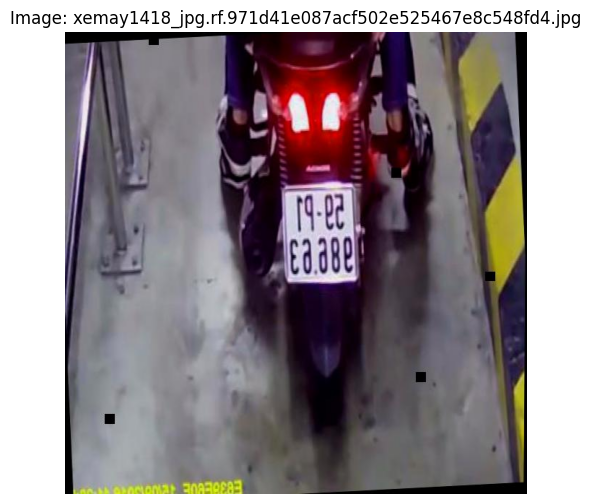

Image path: /kaggle/input/cv-project-dataset/train/images/xemay1418_jpg.rf.971d41e087acf502e525467e8c548fd4.jpg
Image shape: (640, 640, 3)
-------------------------------------------


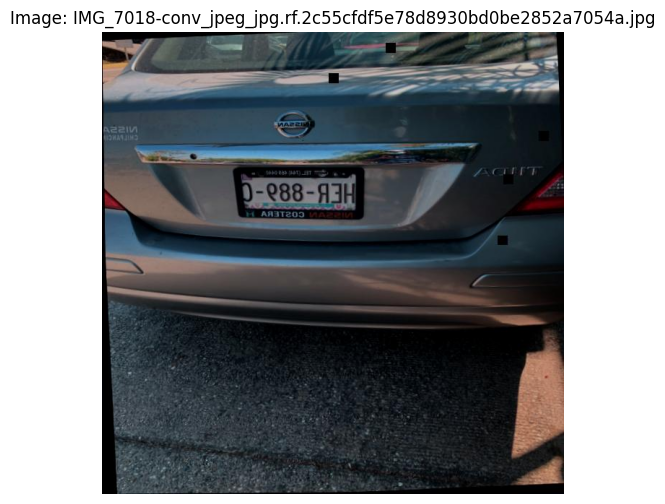

Image path: /kaggle/input/cv-project-dataset/train/images/IMG_7018-conv_jpeg_jpg.rf.2c55cfdf5e78d8930bd0be2852a7054a.jpg
Image shape: (640, 640, 3)
-------------------------------------------


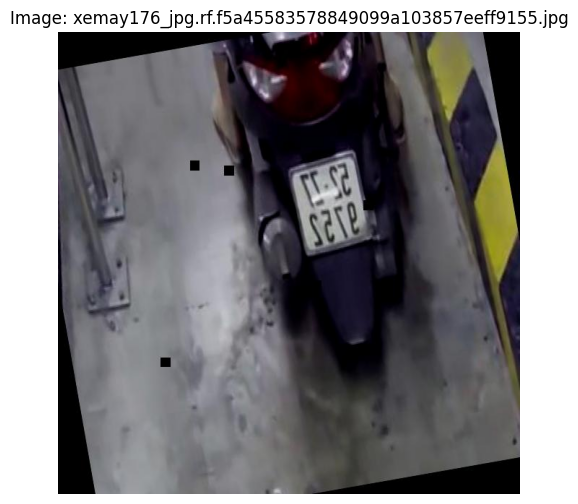

Image path: /kaggle/input/cv-project-dataset/train/images/xemay176_jpg.rf.f5a45583578849099a103857eeff9155.jpg
Image shape: (640, 640, 3)
-------------------------------------------


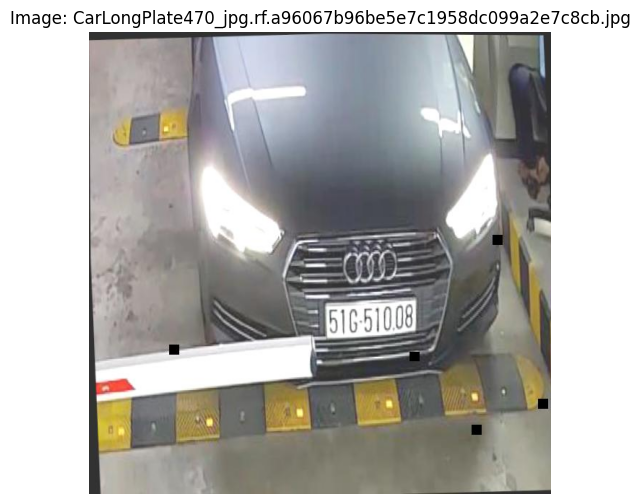

Image path: /kaggle/input/cv-project-dataset/train/images/CarLongPlate470_jpg.rf.a96067b96be5e7c1958dc099a2e7c8cb.jpg
Image shape: (640, 640, 3)
-------------------------------------------


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
import random

# Define dataset path
dataset_path = "/kaggle/input/cv-project-dataset"

# Function to get a small random sample of images from train or test set
def get_sample_images(subset="train", num_samples=10):
    image_path = os.path.join(dataset_path, subset, "images")
    all_images = glob(os.path.join(image_path, "*.jpg")) + glob(os.path.join(image_path, "*.png"))
    
    if len(all_images) == 0:
        print(f"No images found in {image_path}")
        return []
    
    return random.sample(all_images, min(num_samples, len(all_images)))

# Get sample images from train set
sample_images = get_sample_images(subset="train", num_samples=5)

# Display sample images
for img_path in sample_images:
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
    
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title(f"Image: {os.path.basename(img_path)}")
    plt.axis('off')
    plt.show()
    
    print(f"Image path: {img_path}")
    print(f"Image shape: {img.shape}")
    print("-------------------------------------------")

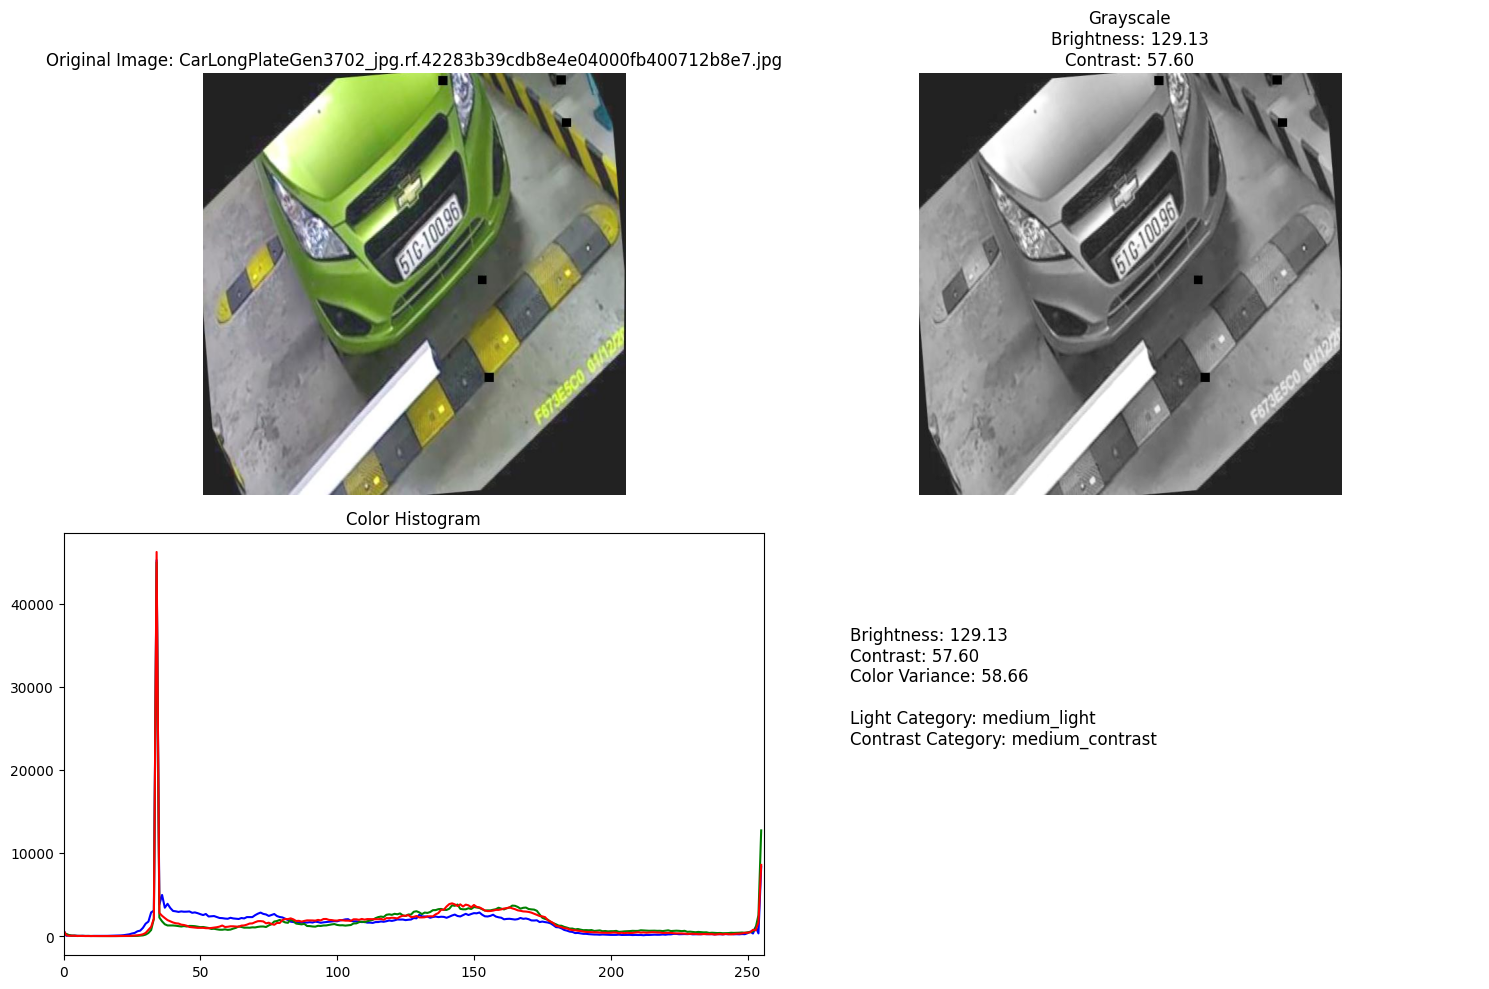

In [2]:
def analyze_image(image_path):
    # Read the image
    img = cv2.imread(image_path)
    
    if img is None:
        print(f"Could not read image: {image_path}")
        return None
    
    # Convert to different color spaces for analysis
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Calculate brightness (using HSV Value channel average)
    brightness = np.mean(hsv[:,:,2])
    
    # Calculate contrast (using standard deviation of grayscale image)
    contrast = np.std(gray)
    
    # Calculate color histogram
    hist_b = cv2.calcHist([img], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([img], [1], None, [256], [0, 256])
    hist_r = cv2.calcHist([img], [2], None, [256], [0, 256])
    
    # Calculate color distribution metrics
    color_variance = np.std(img, axis=(0,1)).mean()
    
    # Determine image category based on metrics
    if brightness < 70:
        light_category = "low_light"
    elif brightness < 130:
        light_category = "medium_light"
    else:
        light_category = "bright"
        
    if contrast < 40:
        contrast_category = "low_contrast"
    elif contrast < 80:
        contrast_category = "medium_contrast"
    else:
        contrast_category = "high_contrast"
    
    return {
        "path": image_path,
        "brightness": brightness,
        "contrast": contrast,
        "color_variance": color_variance,
        "light_category": light_category,
        "contrast_category": contrast_category,
        "histogram": (hist_b, hist_g, hist_r)
    }

# Function to visualize the analysis
def visualize_analysis(image_info):
    img = cv2.imread(image_info["path"])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15, 10))
    
    # Display original image
    plt.subplot(2, 2, 1)
    plt.imshow(img_rgb)
    plt.title(f"Original Image: {os.path.basename(image_info['path'])}")
    plt.axis('off')
    
    # Display grayscale image
    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap='gray')
    plt.title(f"Grayscale\nBrightness: {image_info['brightness']:.2f}\nContrast: {image_info['contrast']:.2f}")
    plt.axis('off')
    
    # Display color histogram
    plt.subplot(2, 2, 3)
    hist_b, hist_g, hist_r = image_info["histogram"]
    plt.plot(hist_b, color='blue')
    plt.plot(hist_g, color='green')
    plt.plot(hist_r, color='red')
    plt.title("Color Histogram")
    plt.xlim([0, 256])
    
    # Display analysis results
    plt.subplot(2, 2, 4)
    plt.axis('off')
    info_text = (
        f"Brightness: {image_info['brightness']:.2f}\n"
        f"Contrast: {image_info['contrast']:.2f}\n"
        f"Color Variance: {image_info['color_variance']:.2f}\n\n"
        f"Light Category: {image_info['light_category']}\n"
        f"Contrast Category: {image_info['contrast_category']}"
    )
    plt.text(0.1, 0.5, info_text, fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Analyze and visualize the first image from our sample
if sample_images:
    image_info = analyze_image(sample_images[0])
    if image_info:
        visualize_analysis(image_info)

In [3]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Example: Move a tensor to GPU
x = torch.randn(3, 3).to(device)
print("Tensor on device:", x.device)


Using device: cuda
Tensor on device: cuda:0


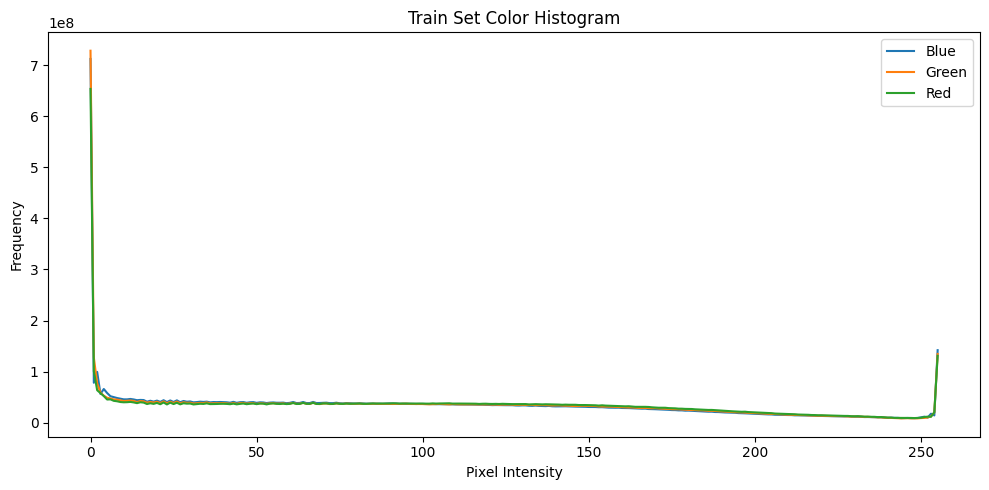

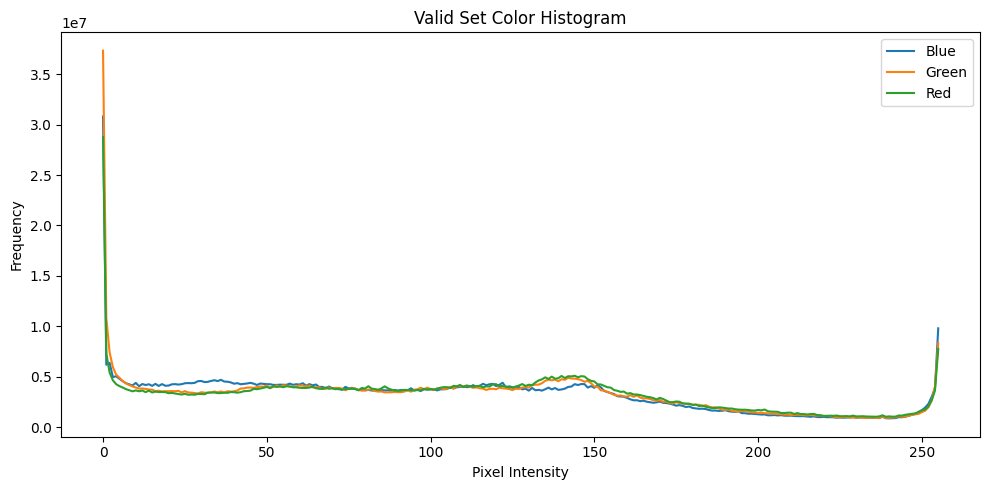

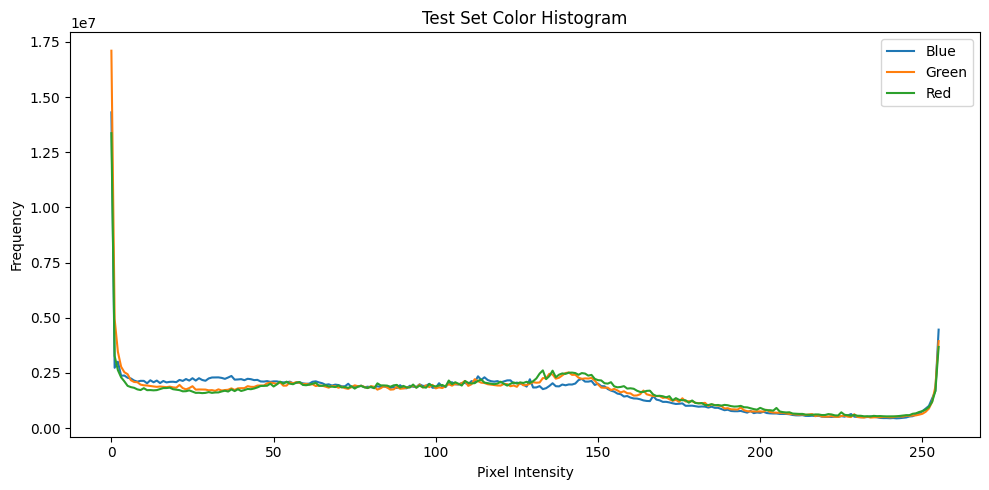

In [1]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def plot_dataset_histogram(dataset_root, split='train'):
    images_dir = Path(dataset_root) / split / 'images'
    valid_exts = {'.jpg', '.jpeg', '.png', '.bmp'}

    # accumulators
    acc_b = acc_g = acc_r = None

    for img_path in images_dir.iterdir():
        if img_path.suffix.lower() not in valid_exts:
            continue
        img = cv2.imread(str(img_path))
        if img is None:
            continue

        # per‑channel hist
        h_b = cv2.calcHist([img], [0], None, [256], [0,256]).flatten()
        h_g = cv2.calcHist([img], [1], None, [256], [0,256]).flatten()
        h_r = cv2.calcHist([img], [2], None, [256], [0,256]).flatten()

        if acc_b is None:
            acc_b, acc_g, acc_r = h_b, h_g, h_r
        else:
            acc_b += h_b
            acc_g += h_g
            acc_r += h_r

    # plot
    plt.figure(figsize=(10,5))
    plt.plot(acc_b, label='Blue')
    plt.plot(acc_g, label='Green')
    plt.plot(acc_r, label='Red')
    plt.title(f'{split.capitalize()} Set Color Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Example usage:
dataset_root = "/kaggle/input/cv-project-dataset"
for split in ['train', 'valid', 'test']:
    plot_dataset_histogram(dataset_root, split)


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import tqdm
import shutil
import yaml

class ImageAnalyzer:
    def __init__(self, use_gpu=True):
        # Thresholds for categorization
        self.light_thresholds = {
            'low': 70,
            'medium': 130
        }
        self.contrast_thresholds = {
            'low': 40, 
            'medium': 80
        }
        # Set GPU usage
        self.use_gpu = use_gpu
        if use_gpu:
            try:
                # Check if CUDA is available with OpenCV
                cv_build_info = cv2.getBuildInformation()
                if "CUDA:YES" in cv_build_info:
                    print("OpenCV built with CUDA support - GPU acceleration enabled")
                    # Enable CUDA for OpenCV operations
                    cv2.setUseOptimized(True)
                    cv2.cuda.setDevice(0)  # Use first GPU
                else:
                    print("OpenCV not built with CUDA support - falling back to CPU")
                    self.use_gpu = False
            except Exception as e:
                print(f"Error setting up GPU: {e}")
                self.use_gpu = False
        
    def analyze_image(self, image_path):
        """Analyze an image for light, contrast and other properties"""
        # Read the image
        img = cv2.imread(str(image_path))
        
        if img is None:
            print(f"Could not read image: {image_path}")
            return None
        
        # Process on GPU if available
        if self.use_gpu:
            try:
                # Upload image to GPU
                gpu_img = cv2.cuda_GpuMat()
                gpu_img.upload(img)
                
                # Convert to grayscale on GPU
                gpu_gray = cv2.cuda.cvtColor(gpu_img, cv2.COLOR_BGR2GRAY)
                gray = gpu_gray.download()
                
                # Convert to HSV on GPU
                gpu_hsv = cv2.cuda.cvtColor(gpu_img, cv2.COLOR_BGR2HSV)
                hsv = gpu_hsv.download()
                
                # Canny edge detection on GPU
                gpu_edges = cv2.cuda.createCannyEdgeDetector(100, 200).detect(gpu_gray)
                edges = gpu_edges.download()
            except Exception as e:
                print(f"GPU processing failed: {e}. Falling back to CPU.")
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                edges = cv2.Canny(gray, 100, 200)
        else:
            # Process on CPU
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            edges = cv2.Canny(gray, 100, 200)
        
        # Get image dimensions for size analysis
        height, width = img.shape[:2]
        size = height * width
        
        # Calculate brightness (using HSV Value channel average)
        brightness = np.mean(hsv[:,:,2])
        
        # Calculate contrast (using standard deviation of grayscale image)
        contrast = np.std(gray)
        
        # Calculate color histogram
        hist_b = cv2.calcHist([img], [0], None, [256], [0, 256])
        hist_g = cv2.calcHist([img], [1], None, [256], [0, 256])
        hist_r = cv2.calcHist([img], [2], None, [256], [0, 256])
        
        # Calculate color distribution metrics
        color_variance = np.std(img, axis=(0,1)).mean()
        
        # Histogram peaks and valleys analysis
        hist_sum = hist_b + hist_g + hist_r
        hist_peaks = np.sum(hist_sum > np.mean(hist_sum) * 1.5)
        
        # Edge detection for feature analysis
        edge_density = np.sum(edges > 0) / size
        
        # Determine image category based on metrics
        if brightness < self.light_thresholds['low']:
            light_category = "low_light"
        elif brightness < self.light_thresholds['medium']:
            light_category = "medium_light"
        else:
            light_category = "bright"
            
        if contrast < self.contrast_thresholds['low']:
            contrast_category = "low_contrast"
        elif contrast < self.contrast_thresholds['medium']:
            contrast_category = "medium_contrast"
        else:
            contrast_category = "high_contrast"
        
        # Combined category for easier referencing
        combined_category = f"{light_category}_{contrast_category}"
        
        # Vehicle size heuristic (assuming vehicle images)
        vehicle_size_category = "small_vehicle" if edge_density < 0.05 else "normal_vehicle"
        
        return {
            "path": str(image_path),
            "filename": os.path.basename(image_path),
            "size": size,
            "brightness": brightness,
            "contrast": contrast,
            "color_variance": color_variance,
            "edge_density": edge_density,
            "hist_peaks": hist_peaks,
            "light_category": light_category,
            "contrast_category": contrast_category,
            "combined_category": combined_category,
            "vehicle_size_category": vehicle_size_category,
            "histogram": (hist_b, hist_g, hist_r)
        }
    
    def visualize_analysis(self, image_info):
        """Generate visualization for a single image analysis"""
        img = cv2.imread(image_info["path"])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        plt.figure(figsize=(15, 10))
        
        # Display original image
        plt.subplot(2, 3, 1)
        plt.imshow(img_rgb)
        plt.title(f"Original: {os.path.basename(image_info['path'])}")
        plt.axis('off')
        
        # Display grayscale image
        plt.subplot(2, 3, 2)
        plt.imshow(gray, cmap='gray')
        plt.title(f"Grayscale\nBrightness: {image_info['brightness']:.2f}\nContrast: {image_info['contrast']:.2f}")
        plt.axis('off')
        
        # Display edge detection
        edges = cv2.Canny(gray, 100, 200)
        plt.subplot(2, 3, 3)
        plt.imshow(edges, cmap='gray')
        plt.title(f"Edge Detection\nEdge Density: {image_info['edge_density']:.4f}")
        plt.axis('off')
        
        # Display color histogram
        plt.subplot(2, 3, 4)
        hist_b, hist_g, hist_r = image_info["histogram"]
        plt.plot(hist_b, color='blue')
        plt.plot(hist_g, color='green')
        plt.plot(hist_r, color='red')
        plt.title("Color Histogram")
        plt.xlim([0, 256])
        
        # Display analysis results
        plt.subplot(2, 3, 5)
        plt.axis('off')
        info_text = (
            f"Brightness: {image_info['brightness']:.2f}\n"
            f"Contrast: {image_info['contrast']:.2f}\n"
            f"Color Variance: {image_info['color_variance']:.2f}\n"
            f"Edge Density: {image_info['edge_density']:.4f}\n"
            f"Histogram Peaks: {image_info['hist_peaks']}\n\n"
            f"Light Category: {image_info['light_category']}\n"
            f"Contrast Category: {image_info['contrast_category']}\n"
            f"Vehicle Size: {image_info['vehicle_size_category']}"
        )
        plt.text(0.1, 0.5, info_text, fontsize=10)
        
        plt.tight_layout()
        return plt.gcf()
    
    def detect_optimal_thresholds(self, image_data_list):
        """Use clustering to find optimal thresholds for the dataset"""
        if not image_data_list:
            return None, None
            
        # Extract features for clustering
        features = np.array([[item['brightness'], item['contrast']] for item in image_data_list])
        
        # Use KMeans to find clusters for brightness and contrast
        kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
        kmeans.fit(features)
        
        # Extract cluster centers and sort them
        centers = kmeans.cluster_centers_
        
        # Update thresholds based on the clusters
        brightness_centers = sorted(centers[:, 0])
        contrast_centers = sorted(centers[:, 1])
        
        # Set thresholds at midpoints between clusters
        self.light_thresholds = {
            'low': (brightness_centers[0] + brightness_centers[1]) / 2,
            'medium': (brightness_centers[1] + brightness_centers[2]) / 2
        }
        
        self.contrast_thresholds = {
            'low': (contrast_centers[0] + contrast_centers[1]) / 2,
            'medium': (contrast_centers[1] + contrast_centers[2]) / 2
        }
        
        print(f"Updated light thresholds: {self.light_thresholds}")
        print(f"Updated contrast thresholds: {self.contrast_thresholds}")
        
        return features, kmeans.labels_
    
    def visualize_clusters(self, features, labels):
        """Visualize the clusters of images based on brightness and contrast"""
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis', alpha=0.7)
        plt.xlabel('Brightness')
        plt.ylabel('Contrast')
        plt.title('Image Clusters by Brightness and Contrast')
        
        # Plot thresholds
        plt.axvline(x=self.light_thresholds['low'], color='r', linestyle='--')
        plt.axvline(x=self.light_thresholds['medium'], color='r', linestyle='--')
        plt.axhline(y=self.contrast_thresholds['low'], color='g', linestyle='--')
        plt.axhline(y=self.contrast_thresholds['medium'], color='g', linestyle='--')
        
        # Add annotations
        plt.text(self.light_thresholds['low'], plt.ylim()[1]*0.95, 'Low Light', ha='right')
        plt.text(self.light_thresholds['medium'], plt.ylim()[1]*0.95, 'Medium Light', ha='right')
        plt.text(plt.xlim()[1]*0.95, self.contrast_thresholds['low'], 'Low Contrast', va='top')
        plt.text(plt.xlim()[1]*0.95, self.contrast_thresholds['medium'], 'Medium Contrast', va='top')
        
        # Add legend - Fix for the add_artist issue
        plt.legend(*scatter.legend_elements(), loc="lower right", title="Clusters")
        
        plt.tight_layout()
        return plt.gcf()

class CVDatasetProcessor:
    def __init__(self, dataset_root, use_gpu=True):
        """
        Initialize the processor with the root directory of the CV dataset
        
        Args:
            dataset_root: Path to the cv-project-dataset folder
            use_gpu: Whether to use GPU acceleration when available
        """
        self.dataset_root = Path(dataset_root)
        self.analyzer = ImageAnalyzer(use_gpu=use_gpu)
        self.analyzed_data = {
            'train': [],
            'test': [],
            'valid': []
        }
        self.valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
        
        # Read data.yaml if it exists
        self.yaml_path = self.dataset_root / 'data.yaml'
        self.dataset_info = None
        if self.yaml_path.exists():
            with open(self.yaml_path, 'r') as f:
                self.dataset_info = yaml.safe_load(f)
                print(f"Loaded dataset info: {self.dataset_info}")
                
    def is_valid_image(self, file_path):
        """Check if a file is a valid image based on extension"""
        return file_path.suffix.lower() in self.valid_extensions
        
    def analyze_dataset(self, subset='train', max_images=None, adaptive_thresholds=True):
        """
        Analyze images in the specified subset (train, test, or valid)
        
        Args:
            subset: One of 'train', 'test', or 'valid'
            max_images: Maximum number of images to analyze (for testing)
            adaptive_thresholds: Whether to adapt thresholds based on the dataset
        """
        subset_path = self.dataset_root / subset / 'images'
        if not subset_path.exists():
            print(f"Error: Path {subset_path} does not exist")
            return None, None
            
        image_paths = [f for f in subset_path.iterdir() 
                      if f.is_file() and self.is_valid_image(f)]
        
        if max_images:
            image_paths = image_paths[:max_images]
            
        print(f"Analyzing {len(image_paths)} images from {subset} set...")
        
        # Process each image
        self.analyzed_data[subset] = []
        for img_path in tqdm(image_paths):
            result = self.analyzer.analyze_image(img_path)
            if result:
                self.analyzed_data[subset].append(result)
        
        # Adaptive thresholds based on the dataset
        if adaptive_thresholds and self.analyzed_data[subset]:
            features, labels = self.analyzer.detect_optimal_thresholds(self.analyzed_data[subset])
            return features, labels
        
        return None, None
    
    def analyze_all_sets(self, max_images=None):
        """Analyze all three sets in the dataset"""
        results = {}
        for subset in ['train', 'test', 'valid']:
            subset_path = self.dataset_root / subset
            if subset_path.exists():
                print(f"\nProcessing {subset} set:")
                features, labels = self.analyze_dataset(subset, max_images)
                results[subset] = (features, labels)
            else:
                print(f"Skipping {subset} set - directory not found")
        return results
            
    def generate_summary(self, subset='all'):
        """Generate a summary of the image analysis results"""
        if subset == 'all':
            # Combine all data
            all_data = []
            for data_list in self.analyzed_data.values():
                all_data.extend(data_list)
        else:
            all_data = self.analyzed_data.get(subset, [])
            
        if not all_data:
            print("No data available for summary")
            return None, None
            
        # Convert to DataFrame for easier analysis
        df = pd.DataFrame([
            {k: v for k, v in data.items() if k != 'histogram'} 
            for data in all_data
        ])
        
        # Generate summary statistics
        summary = {
            'total_images': len(df),
            'light_categories': df['light_category'].value_counts().to_dict(),
            'contrast_categories': df['contrast_category'].value_counts().to_dict(),
            'vehicle_sizes': df['vehicle_size_category'].value_counts().to_dict(),
            'mean_brightness': df['brightness'].mean(),
            'mean_contrast': df['contrast'].mean(),
            'brightness_std': df['brightness'].std(),
            'contrast_std': df['contrast'].std(),
        }
        
        # Create combined categories (e.g., low_light + low_contrast)
        if 'combined_category' not in df.columns:
            df['combined_category'] = df['light_category'] + '_' + df['contrast_category']
            
        summary['combined_categories'] = df['combined_category'].value_counts().to_dict()
        
        return summary, df
    
    def visualize_summary(self, summary, df):
        """Create visualizations of the dataset summary"""
        if summary is None or df is None or df.empty:
            print("No data to visualize")
            return None
            
        plt.figure(figsize=(18, 12))
        
        # Light condition distribution
        plt.subplot(2, 3, 1)
        light_keys = list(summary['light_categories'].keys())
        light_values = list(summary['light_categories'].values())
        sns.barplot(x=light_keys, y=light_values)
        plt.title('Light Condition Distribution')
        plt.xticks(rotation=45)
        
        # Contrast distribution
        plt.subplot(2, 3, 2)
        contrast_keys = list(summary['contrast_categories'].keys())
        contrast_values = list(summary['contrast_categories'].values())
        sns.barplot(x=contrast_keys, y=contrast_values)
        plt.title('Contrast Distribution')
        plt.xticks(rotation=45)
        
        # Vehicle size distribution
        plt.subplot(2, 3, 3)
        vehicle_keys = list(summary['vehicle_sizes'].keys())
        vehicle_values = list(summary['vehicle_sizes'].values())
        sns.barplot(x=vehicle_keys, y=vehicle_values)
        plt.title('Vehicle Size Distribution')
        plt.xticks(rotation=45)
        
        # Scatter plot of brightness vs contrast
        plt.subplot(2, 3, 4)
        scatter = sns.scatterplot(x=df['brightness'], y=df['contrast'], 
                                 hue=df['combined_category'], alpha=0.7)
        plt.title('Brightness vs Contrast')
        # Handle legend differently to avoid add_artist
        plt.legend(title="Categories", bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Histogram of brightness values
        plt.subplot(2, 3, 5)
        sns.histplot(x=df['brightness'], kde=True)
        plt.title('Brightness Distribution')
        
        # Histogram of contrast values
        plt.subplot(2, 3, 6)
        sns.histplot(x=df['contrast'], kde=True)
        plt.title('Contrast Distribution')
        
        plt.tight_layout()
        return plt.gcf()
    
    def create_segregated_subsets(self, output_dir, subset='train', copy_labels=True):
        """
        Create segregated dataset folders based on light and contrast categories
        
        Args:
            output_dir: Directory where to save the segregated subsets
            subset: Which subset to process ('train', 'test', or 'valid')
            copy_labels: Whether to copy the corresponding label files
        """
        if not self.analyzed_data.get(subset):
            print(f"No analyzed data for {subset}")
            return None
            
        output_path = Path(output_dir)
        if not output_path.exists():
            output_path.mkdir(parents=True)
            
        # Group images by categories
        category_images = {}
        for img_data in self.analyzed_data[subset]:
            category = img_data['combined_category']
            
            if category not in category_images:
                category_images[category] = []
                
            category_images[category].append(img_data)
            
        # Create subdirectories and copy files
        for category, images in category_images.items():
            # Create category directory
            category_dir = output_path / category / 'images'
            category_dir.mkdir(parents=True, exist_ok=True)
            
            if copy_labels:
                label_dir = output_path / category / 'labels'
                label_dir.mkdir(parents=True, exist_ok=True)
                
            # Copy each image to its category directory
            for img_data in images:
                # Copy image
                src_path = Path(img_data['path'])
                dst_path = category_dir / src_path.name
                shutil.copy2(src_path, dst_path)
                
                # Copy label if needed
                if copy_labels:
                    # Determine label path - usually same name but different extension
                    label_src = (self.dataset_root / subset / 'labels' / 
                              src_path.stem).with_suffix('.txt')
                    
                    if label_src.exists():
                        label_dst = label_dir / label_src.name
                        shutil.copy2(label_src, label_dst)
                        
        print(f"Created {len(category_images)} segregated subsets in {output_path}")
        # Return statistics about the categories
        category_stats = {cat: len(imgs) for cat, imgs in category_images.items()}
        return category_stats

def main():
    # Path to your dataset
    dataset_path = "/kaggle/input/cv-project-dataset"  # Update with your actual path
    
    # Initialize the processor with GPU support
    processor = CVDatasetProcessor(dataset_path, use_gpu=True)
    
    # First test on a small subset (10-15 images as recommended)
    print("Testing on a small subset of images...")
    features, labels = processor.analyze_dataset(subset='train', max_images=15, adaptive_thresholds=True)
    
    # Visualize the clusters
    if features is not None and labels is not None:
        try:
            cluster_fig = processor.analyzer.visualize_clusters(features, labels)
            plt.savefig('cluster_analysis.png')
            print("Saved cluster analysis to 'cluster_analysis.png'")
            plt.close()
        except Exception as e:
            print(f"Error visualizing clusters: {e}")
    
    # Generate and visualize summary
    summary, df = processor.generate_summary('train')
    if summary is not None and df is not None:
        try:
            summary_fig = processor.visualize_summary(summary, df)
            plt.savefig('dataset_summary.png')
            print("Saved dataset summary to 'dataset_summary.png'")
            plt.close()
        except Exception as e:
            print(f"Error visualizing summary: {e}")
    
    # Create segregated dataset
    category_stats = processor.create_segregated_subsets('segregated_dataset', subset='train')
    if category_stats:
        print("\nCategory distribution in segregated dataset:")
        for category, count in category_stats.items():
            print(f"  {category}: {count} images")
    
    # Ask to process the full dataset
    print("\nDo you want to process the full dataset? (y/n)")
    try:
        response = input().strip().lower()
        
        if response == 'y':
            print("\nProcessing full dataset...")
            processor.analyze_all_sets()
            
            # Create segregated datasets for all subsets
            for subset in ['train', 'test', 'valid']:
                subset_path = processor.dataset_root / subset
                if subset_path.exists():
                    stats = processor.create_segregated_subsets(f'segregated_dataset/{subset}', subset=subset)
                    if stats:
                        print(f"\n{subset} subset distribution:")
                        for category, count in stats.items():
                            print(f"  {category}: {count} images")
            
            print("\nFull dataset processing complete!")
        else:
            print("\nSkipping full dataset processing.")
    except Exception as e:
        print(f"Error during user interaction: {e}")
        print("Proceeding with creating segregated dataset from analyzed data...")
        
        # Process the subset we already analyzed
        for subset, data in processor.analyzed_data.items():
            if data:
                processor.create_segregated_subsets(f'segregated_dataset/{subset}', subset=subset)

if __name__ == "__main__":
    main()

OpenCV not built with CUDA support - falling back to CPU
Loaded dataset info: {'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 1, 'names': ['License_Plate'], 'roboflow': {'workspace': 'roboflow-universe-projects', 'project': 'license-plate-recognition-rxg4e', 'version': 4, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/roboflow-universe-projects/license-plate-recognition-rxg4e/dataset/4'}}
Testing on a small subset of images...
Analyzing 15 images from train set...


100%|██████████| 15/15 [00:00<00:00, 18.13it/s]


Updated light thresholds: {'low': 71.59571728515625, 'medium': 120.76570159040178}
Updated contrast thresholds: {'low': 58.12373611293254, 'medium': 63.69943583756654}
Saved cluster analysis to 'cluster_analysis.png'


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/loc

Saved dataset summary to 'dataset_summary.png'
Created 6 segregated subsets in segregated_dataset

Category distribution in segregated dataset:
  medium_light_high_contrast: 1 images
  medium_light_medium_contrast: 4 images
  low_light_medium_contrast: 3 images
  bright_low_contrast: 1 images
  bright_medium_contrast: 5 images
  bright_high_contrast: 1 images

Do you want to process the full dataset? (y/n)


 y



Processing full dataset...

Processing train set:
Analyzing 21173 images from train set...


100%|██████████| 21173/21173 [20:35<00:00, 17.13it/s]


Updated light thresholds: {'low': 83.24696266726552, 'medium': 130.1109849014578}
Updated contrast thresholds: {'low': 56.98446040970855, 'medium': 61.66495443158213}

Processing test set:
Analyzing 1019 images from test set...


100%|██████████| 1019/1019 [00:59<00:00, 17.11it/s]


Updated light thresholds: {'low': 98.80119739529664, 'medium': 139.46123984429997}
Updated contrast thresholds: {'low': 59.64329559220988, 'medium': 63.38551999034836}

Processing valid set:
Analyzing 2046 images from valid set...


100%|██████████| 2046/2046 [01:59<00:00, 17.06it/s]


Updated light thresholds: {'low': 96.71202541027661, 'medium': 140.2394989902511}
Updated contrast thresholds: {'low': 59.45533432115015, 'medium': 62.7215420843376}
Created 9 segregated subsets in segregated_dataset/train

train subset distribution:
  medium_light_high_contrast: 3610 images
  low_light_low_contrast: 3100 images
  low_light_medium_contrast: 786 images
  bright_low_contrast: 3338 images
  bright_high_contrast: 2524 images
  medium_light_low_contrast: 3675 images
  medium_light_medium_contrast: 2018 images
  bright_medium_contrast: 1555 images
  low_light_high_contrast: 567 images
Created 9 segregated subsets in segregated_dataset/test

test subset distribution:
  medium_light_low_contrast: 297 images
  medium_light_high_contrast: 273 images
  low_light_high_contrast: 62 images
  medium_light_medium_contrast: 90 images
  bright_medium_contrast: 35 images
  low_light_low_contrast: 59 images
  bright_high_contrast: 91 images
  bright_low_contrast: 91 images
  low_light_med

In [7]:
import shutil

# Zip the entire folder
shutil.make_archive('segregated_dataset', 'zip', 'segregated_dataset')


'/kaggle/working/segregated_dataset.zip'

Processing dataset with Laplacian blur detection...


Calibrating blur threshold: 100%|██████████| 15/15 [00:00<00:00, 170.86it/s]


Calibrated blur threshold: 163.85
Processing 6 categories


Processing categories: 100%|██████████| 6/6 [00:00<00:00, 73.61it/s]


Multi-dimensional Classification Summary:
Total images processed: 15
Total multi-dimensional categories: 8

Blur category distribution:
  sharp: 10 images (66.7%)
  blurry: 5 images (33.3%)

Top multi-dimensional categories:
  medium_light_medium_contrast_sharp: 4 images (26.7%)
  bright_medium_contrast_sharp: 3 images (20.0%)
  bright_medium_contrast_blurry: 2 images (13.3%)
  low_light_medium_contrast_blurry: 2 images (13.3%)
  bright_high_contrast_sharp: 1 images (6.7%)
  low_light_medium_contrast_sharp: 1 images (6.7%)
  medium_light_high_contrast_sharp: 1 images (6.7%)
  bright_low_contrast_blurry: 1 images (6.7%)



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_31/1235337181.py:312: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 4)


Saved analysis visualization to 'multidimensional_analysis.png'

Processing complete! Multi-dimensional dataset created at:
  segregated_dataset_multidim

Sample classifications for 5 images:
  CarLongPlateGen3815_jpg.rf.761d7bb2a92bbd01d05b74cfc0a2c8b3.jpg: low_light_medium_contrast_blurry
  CarLongPlateGen2433_jpg.rf.b4672a6dae38dee60aa85cc841c970bb.jpg: low_light_medium_contrast_blurry
  CarLongPlateGen3891_jpg.rf.0e5d8c8a9b6febd74fad43452e882415.jpg: low_light_medium_contrast_sharp
  CarLongPlateGen2805_jpg.rf.f1fc62461a1e8403ff4fd41a2aa59ff6.jpg: bright_high_contrast_sharp
  CarLongPlate542_jpg.rf.e1f78359f1cd064d46d4b3548bda305f.jpg: bright_medium_contrast_sharp


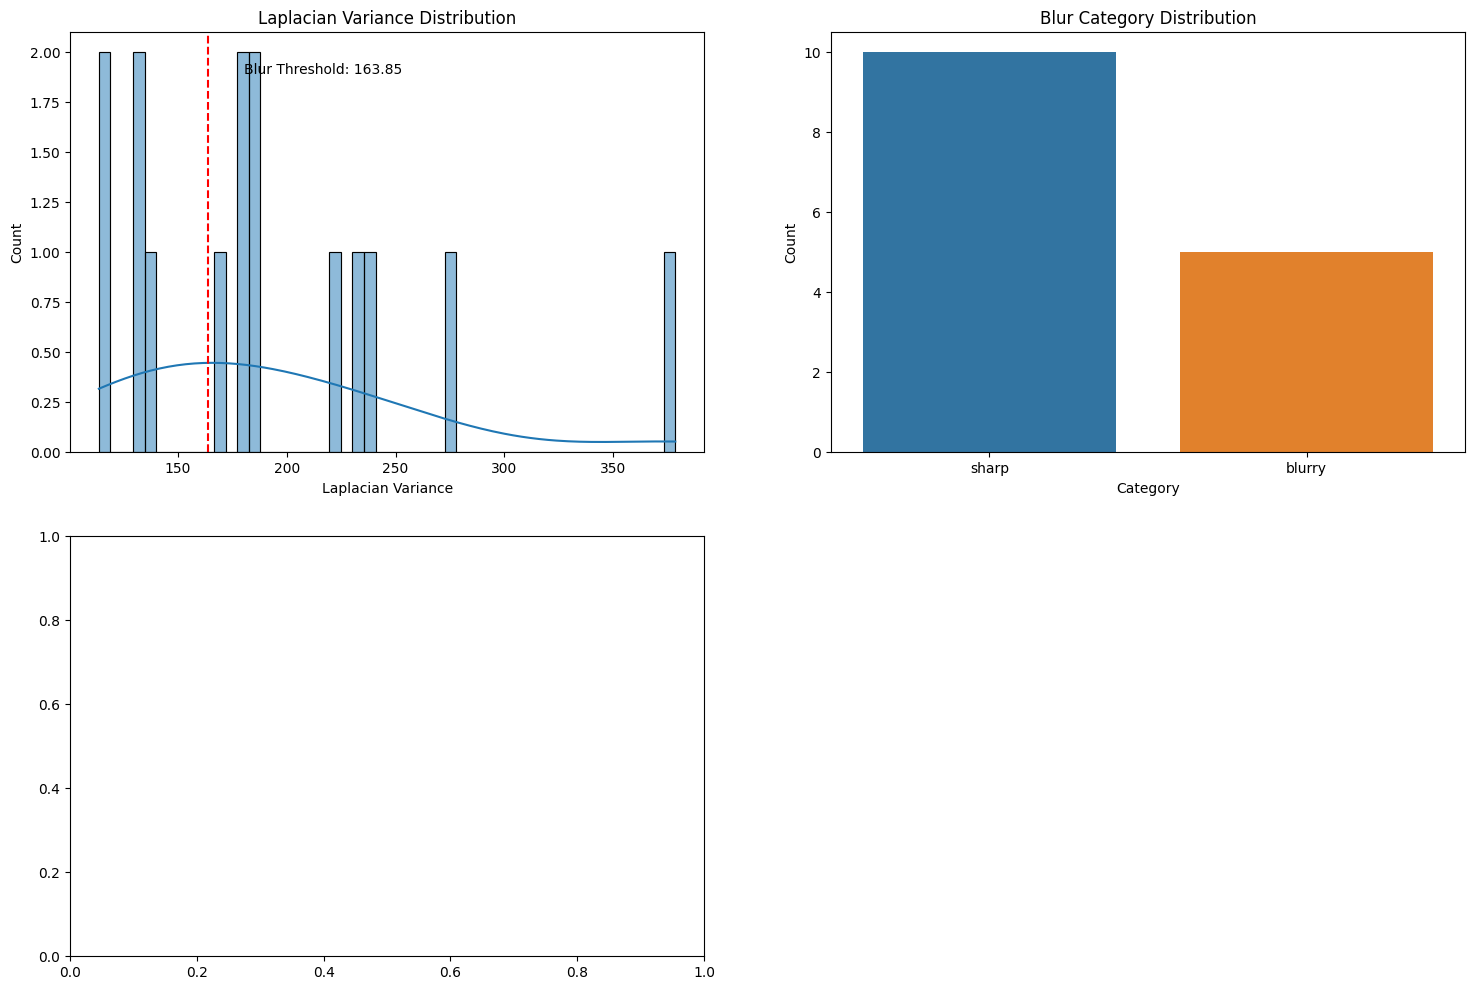

In [8]:
import cv2
import numpy as np
import os
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

class LaplacianAnalyzer:
    def __init__(self, blur_threshold=None):
        """
        Initialize the Laplacian analyzer for blur detection
        
        Args:
            blur_threshold: Threshold value for determining blurry vs sharp images.
                           If None, will be determined adaptively from the dataset.
        """
        self.blur_threshold = blur_threshold
    
    def detect_blur(self, image_path):
        """
        Analyze an image using Laplacian variance to detect blur
        
        Args:
            image_path: Path to the image file
            
        Returns:
            Dictionary with blur metrics and classification
        """
        # Read the image
        img = cv2.imread(str(image_path))
        
        if img is None:
            print(f"Could not read image: {image_path}")
            return None
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Calculate Laplacian variance
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        laplacian_var = laplacian.var()
        
        # Classify as blurry or sharp
        is_blurry = laplacian_var < (self.blur_threshold if self.blur_threshold else 100)
        blur_category = "blurry" if is_blurry else "sharp"
        
        return {
            "path": str(image_path),
            "filename": os.path.basename(image_path),
            "laplacian_var": laplacian_var,
            "blur_category": blur_category
        }
    
    def calibrate_threshold(self, image_paths, percentile=35):
        """
        Calibrate the blur threshold based on analyzing a set of images
        
        Args:
            image_paths: List of paths to images
            percentile: Percentile to use for threshold (lower = more images marked as blurry)
            
        Returns:
            Calibrated threshold value
        """
        variances = []
        
        for img_path in tqdm(image_paths, desc="Calibrating blur threshold"):
            img = cv2.imread(str(img_path))
            if img is not None:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                laplacian = cv2.Laplacian(gray, cv2.CV_64F)
                variances.append(laplacian.var())
        
        if not variances:
            print("No valid images found for calibration")
            return 100  # Default threshold
        
        # Set threshold at specified percentile
        threshold = np.percentile(variances, percentile)
        self.blur_threshold = threshold
        print(f"Calibrated blur threshold: {threshold:.2f}")
        
        return threshold
    
    def visualize_laplacian(self, image_path):
        """
        Visualize Laplacian operator effects on an image
        
        Args:
            image_path: Path to the image
            
        Returns:
            Matplotlib figure
        """
        img = cv2.imread(str(image_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Calculate Laplacian
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        laplacian_abs = np.uint8(np.absolute(laplacian))
        
        # Visualize
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(img_rgb)
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        axes[1].imshow(gray, cmap='gray')
        axes[1].set_title("Grayscale")
        axes[1].axis('off')
        
        axes[2].imshow(laplacian_abs, cmap='gray')
        axes[2].set_title(f"Laplacian\nVariance: {laplacian.var():.2f}")
        axes[2].axis('off')
        
        plt.tight_layout()
        return fig


class MultiDimensionalClassifier:
    def __init__(self, segregated_dataset_path):
        """
        Process a segregated dataset to add blur detection and create multi-dimensional categories
        
        Args:
            segregated_dataset_path: Path to the dataset already segregated by light and contrast
        """
        self.input_path = Path(segregated_dataset_path)
        self.output_path = self.input_path.parent / f"{self.input_path.name}_multidim"
        self.laplacian_analyzer = LaplacianAnalyzer()
        self.results = []
    
    def process_dataset(self, calibration_sample_size=50):
        """
        Process the entire dataset, adding blur detection
        
        Args:
            calibration_sample_size: Number of images to use for calibrating the blur threshold
        """
        if not self.input_path.exists():
            print(f"Input path does not exist: {self.input_path}")
            return
        
        # Create output directory
        self.output_path.mkdir(parents=True, exist_ok=True)
        
        # Find all image directories
        all_images = []
        category_paths = []
        
        for category_dir in self.input_path.iterdir():
            if category_dir.is_dir():
                img_dir = category_dir / 'images'
                if img_dir.exists():
                    category_paths.append(category_dir)
                    # Collect some images for calibration
                    for img_path in img_dir.iterdir():
                        if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                            all_images.append(img_path)
                            if len(all_images) >= calibration_sample_size:
                                break
        
        # Calibrate blur threshold
        if all_images:
            self.laplacian_analyzer.calibrate_threshold(all_images)
        
        # Process each category
        print(f"Processing {len(category_paths)} categories")
        for category_dir in tqdm(category_paths, desc="Processing categories"):
            category_name = category_dir.name
            img_dir = category_dir / 'images'
            label_dir = category_dir / 'labels'
            
            # Skip if no images directory
            if not img_dir.exists():
                continue
            
            # Process all images in this category
            for img_path in img_dir.iterdir():
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                    # Analyze blur
                    blur_result = self.laplacian_analyzer.detect_blur(img_path)
                    if not blur_result:
                        continue
                    
                    # Combine with existing category info
                    blur_category = blur_result['blur_category']
                    multidim_category = f"{category_name}_{blur_category}"
                    
                    # Create multi-dimensional category directory
                    multidim_img_dir = self.output_path / multidim_category / 'images'
                    multidim_img_dir.mkdir(parents=True, exist_ok=True)
                    
                    # Copy image to new directory
                    dst_path = multidim_img_dir / img_path.name
                    shutil.copy2(img_path, dst_path)
                    
                    # Copy labels if they exist
                    if label_dir.exists():
                        label_path = (label_dir / img_path.stem).with_suffix('.txt')
                        if label_path.exists():
                            multidim_label_dir = self.output_path / multidim_category / 'labels'
                            multidim_label_dir.mkdir(parents=True, exist_ok=True)
                            label_dst = multidim_label_dir / label_path.name
                            shutil.copy2(label_path, label_dst)
                    
                    # Save result for analysis
                    self.results.append({
                        'original_category': category_name,
                        'blur_category': blur_category,
                        'multidim_category': multidim_category,
                        'path': str(img_path),
                        'laplacian_variance': blur_result['laplacian_var']
                    })
    
    def generate_summary(self):
        """
        Generate summary of the multi-dimensional classification
        
        Returns:
            DataFrame with results and summary statistics
        """
        if not self.results:
            print("No results to summarize")
            return None
        
        # Convert to DataFrame
        df = pd.DataFrame(self.results)
        
        # Generate summary
        summary = {
            'total_images': len(df),
            'original_categories': df['original_category'].value_counts().to_dict(),
            'blur_categories': df['blur_category'].value_counts().to_dict(),
            'multidim_categories': df['multidim_category'].value_counts().to_dict(),
            'mean_laplacian_var': df['laplacian_variance'].mean(),
            'median_laplacian_var': df['laplacian_variance'].median(),
            'min_laplacian_var': df['laplacian_variance'].min(),
            'max_laplacian_var': df['laplacian_variance'].max()
        }
        
        print("\nMulti-dimensional Classification Summary:")
        print(f"Total images processed: {summary['total_images']}")
        print(f"Total multi-dimensional categories: {len(summary['multidim_categories'])}")
        
        # Show distribution of blur categories
        print("\nBlur category distribution:")
        for category, count in summary['blur_categories'].items():
            percentage = (count / summary['total_images']) * 100
            print(f"  {category}: {count} images ({percentage:.1f}%)")
        
        # Show top multi-dimensional categories
        print("\nTop multi-dimensional categories:")
        top_categories = dict(sorted(summary['multidim_categories'].items(), 
                                    key=lambda x: x[1], reverse=True)[:10])
        for category, count in top_categories.items():
            percentage = (count / summary['total_images']) * 100
            print(f"  {category}: {count} images ({percentage:.1f}%)")
        
        # Return DataFrame for further analysis
        return df
    
    def visualize_results(self, df):
        """
        Create visualizations of the multi-dimensional classification
        
        Args:
            df: DataFrame with classification results
            
        Returns:
            Matplotlib figure
        """
        if df is None or df.empty:
            return None
        
        fig = plt.figure(figsize=(18, 12))
        
        # Distribution of Laplacian variances
        plt.subplot(2, 2, 1)
        sns.histplot(df['laplacian_variance'], bins=50, kde=True)
        plt.axvline(x=self.laplacian_analyzer.blur_threshold, color='red', linestyle='--')
        plt.title('Laplacian Variance Distribution')
        plt.xlabel('Laplacian Variance')
        plt.ylabel('Count')
        plt.text(self.laplacian_analyzer.blur_threshold * 1.1, 
                plt.ylim()[1] * 0.9, 
                f'Blur Threshold: {self.laplacian_analyzer.blur_threshold:.2f}')
        
        # Distribution of blur categories
        plt.subplot(2, 2, 2)
        blur_counts = df['blur_category'].value_counts()
        sns.barplot(x=blur_counts.index, y=blur_counts.values)
        plt.title('Blur Category Distribution')
        plt.xlabel('Category')
        plt.ylabel('Count')
        
        # Distribution of original categories with blur breakdown
        plt.subplot(2, 2, 3)
        category_blur = pd.crosstab(df['original_category'], df['blur_category'])
        category_blur.plot(kind='bar', stacked=True)
        plt.title('Light-Contrast Categories with Blur Breakdown')
        plt.xlabel('Original Category')
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        
        # Top multi-dimensional categories
        plt.subplot(2, 2, 4)
        top_categories = df['multidim_category'].value_counts().nlargest(10)
        sns.barplot(x=top_categories.values, y=top_categories.index)
        plt.title('Top 10 Multi-dimensional Categories')
        plt.xlabel('Count')
        
        plt.tight_layout()
        return fig


def main():
    # Path to your segregated dataset
    segregated_dataset_path = "./segregated_dataset"
    
    # Initialize the classifier
    classifier = MultiDimensionalClassifier(segregated_dataset_path)
    
    # Process the dataset with blur detection
    print("Processing dataset with Laplacian blur detection...")
    classifier.process_dataset(calibration_sample_size=100)
    
    # Generate and visualize results
    df = classifier.generate_summary()
    if df is not None:
        result_fig = classifier.visualize_results(df)
        plt.savefig('multidimensional_analysis.png')
        print("Saved analysis visualization to 'multidimensional_analysis.png'")
        plt.close()
    
    print(f"\nProcessing complete! Multi-dimensional dataset created at:")
    print(f"  {classifier.output_path}")
    
    # Optional: Display a few sample images with their classifications
    sample_size = min(5, len(classifier.results))
    if classifier.results:
        print(f"\nSample classifications for {sample_size} images:")
        for i in range(sample_size):
            result = classifier.results[i]
            print(f"  {os.path.basename(result['path'])}: {result['multidim_category']}")

if __name__ == "__main__":
    main()

In [14]:
import cv2
import numpy as np
import os
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

class LaplacianAnalyzer:
    def __init__(self, blur_threshold=None):
        """
        Initialize the Laplacian analyzer for blur detection
        
        Args:
            blur_threshold: Threshold value for determining blurry vs sharp images.
                           If None, will be determined adaptively from the dataset.
        """
        self.blur_threshold = blur_threshold
    
    def detect_blur(self, image_path):
        """
        Analyze an image using Laplacian variance to detect blur
        
        Args:
            image_path: Path to the image file
            
        Returns:
            Dictionary with blur metrics and classification
        """
        # Read the image
        img = cv2.imread(str(image_path))
        
        if img is None:
            print(f"Could not read image: {image_path}")
            return None
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Calculate Laplacian variance
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        laplacian_var = laplacian.var()
        
        # Classify as blurry or sharp
        is_blurry = laplacian_var < (self.blur_threshold if self.blur_threshold else 100)
        blur_category = "blurry" if is_blurry else "sharp"
        
        return {
            "path": str(image_path),
            "filename": os.path.basename(image_path),
            "laplacian_var": laplacian_var,
            "blur_category": blur_category
        }
    
    def calibrate_threshold(self, image_paths, percentile=35):
        """
        Calibrate the blur threshold based on analyzing a set of images
        
        Args:
            image_paths: List of paths to images
            percentile: Percentile to use for threshold (lower = more images marked as blurry)
            
        Returns:
            Calibrated threshold value
        """
        variances = []
        
        for img_path in tqdm(image_paths, desc="Calibrating blur threshold"):
            img = cv2.imread(str(img_path))
            if img is not None:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                laplacian = cv2.Laplacian(gray, cv2.CV_64F)
                variances.append(laplacian.var())
        
        if not variances:
            print("No valid images found for calibration")
            return 100  # Default threshold
        
        # Set threshold at specified percentile
        threshold = np.percentile(variances, percentile)
        self.blur_threshold = threshold
        print(f"Calibrated blur threshold: {threshold:.2f}")
        
        return threshold


class FullDatasetProcessor:
    def __init__(self, dataset_root):
        """
        Process a complete dataset to add blur detection and create multi-dimensional categories
        
        Args:
            dataset_root: Path to the dataset root directory
        """
        self.dataset_root = Path(dataset_root)
        self.output_path = self.dataset_root.parent / f"{self.dataset_root.name}_multidim"
        self.laplacian_analyzer = LaplacianAnalyzer()
        self.results = []
        self.valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
        
    def is_valid_image(self, file_path):
        """Check if a file is a valid image based on extension"""
        return file_path.suffix.lower() in self.valid_extensions
    
    def find_category_directories(self):
        """
        Find all category directories in the dataset that contain images
        
        Returns:
            List of tuples with (category_name, category_path, image_dir, label_dir)
        """
        categories = []
        
        # Handle case where dataset structure has multiple subset directories
        # (train, valid, test) containing categories
        for subset_dir in self.dataset_root.iterdir():
            if subset_dir.is_dir():
                # Check if this is a subset directory like "train" or "valid"
                if subset_dir.name in ['train', 'test', 'valid']:
                    # Look for category dirs inside the subset
                    for category_dir in subset_dir.iterdir():
                        if category_dir.is_dir():
                            img_dir = category_dir / 'images'
                            label_dir = category_dir / 'labels'
                            if img_dir.exists():
                                # Use subset_category as the name
                                full_category = f"{subset_dir.name}_{category_dir.name}"
                                categories.append((full_category, category_dir, img_dir, label_dir))
                else:
                    # This is a category directory
                    img_dir = subset_dir / 'images'
                    label_dir = subset_dir / 'labels'
                    if img_dir.exists():
                        categories.append((subset_dir.name, subset_dir, img_dir, label_dir))
        
        return categories
    
    def process_dataset(self, calibration_sample_size=100):
        """
        Process the entire dataset, adding blur detection
        
        Args:
            calibration_sample_size: Number of images to use for calibrating the blur threshold
        """
        if not self.dataset_root.exists():
            print(f"Input path does not exist: {self.dataset_root}")
            return
        
        # Create output directory
        self.output_path.mkdir(parents=True, exist_ok=True)
        
        # Find all category directories
        categories = self.find_category_directories()
        if not categories:
            print(f"No valid category directories found in {self.dataset_root}")
            return
            
        print(f"Found {len(categories)} categories in the dataset")
        
        # Collect images for calibration
        calibration_images = []
        for _, _, img_dir, _ in categories:
            if img_dir.exists():
                for img_path in img_dir.iterdir():
                    if self.is_valid_image(img_path):
                        calibration_images.append(img_path)
                        if len(calibration_images) >= calibration_sample_size:
                            break
                if len(calibration_images) >= calibration_sample_size:
                    break
        
        # Calibrate blur threshold
        if calibration_images:
            self.laplacian_analyzer.calibrate_threshold(calibration_images)
        else:
            print("No images found for calibration, using default threshold")
        
        # Process each category
        for category_name, category_dir, img_dir, label_dir in tqdm(categories, desc="Processing categories"):
            # Skip if no images directory
            if not img_dir.exists():
                continue
                
            # Process all images in this category
            for img_path in img_dir.iterdir():
                if self.is_valid_image(img_path):
                    # Analyze blur
                    blur_result = self.laplacian_analyzer.detect_blur(img_path)
                    if not blur_result:
                        continue
                    
                    # Combine with existing category info
                    blur_category = blur_result['blur_category']
                    multidim_category = f"{category_name}_{blur_category}"
                    
                    # Create multi-dimensional category directory
                    multidim_img_dir = self.output_path / multidim_category / 'images'
                    multidim_img_dir.mkdir(parents=True, exist_ok=True)
                    
                    # Copy image to new directory
                    dst_path = multidim_img_dir / img_path.name
                    shutil.copy2(img_path, dst_path)
                    
                    # Copy labels if they exist
                    if label_dir.exists():
                        label_path = (label_dir / img_path.stem).with_suffix('.txt')
                        if label_path.exists():
                            multidim_label_dir = self.output_path / multidim_category / 'labels'
                            multidim_label_dir.mkdir(parents=True, exist_ok=True)
                            label_dst = multidim_label_dir / label_path.name
                            shutil.copy2(label_path, label_dst)
                    
                    # Save result for analysis
                    self.results.append({
                        'original_category': category_name,
                        'blur_category': blur_category,
                        'multidim_category': multidim_category,
                        'path': str(img_path),
                        'laplacian_variance': blur_result['laplacian_var']
                    })
    
    def generate_summary(self):
        """
        Generate summary of the multi-dimensional classification
        
        Returns:
            DataFrame with results and summary statistics
        """
        if not self.results:
            print("No results to summarize")
            return None
        
        # Convert to DataFrame
        df = pd.DataFrame(self.results)
        
        # Generate summary
        summary = {
            'total_images': len(df),
            'original_categories': df['original_category'].value_counts().to_dict(),
            'blur_categories': df['blur_category'].value_counts().to_dict(),
            'multidim_categories': df['multidim_category'].value_counts().to_dict(),
            'mean_laplacian_var': df['laplacian_variance'].mean(),
            'median_laplacian_var': df['laplacian_variance'].median(),
            'min_laplacian_var': df['laplacian_variance'].min(),
            'max_laplacian_var': df['laplacian_variance'].max()
        }
        
        print("\nMulti-dimensional Classification Summary:")
        print(f"Total images processed: {summary['total_images']}")
        print(f"Total multi-dimensional categories: {len(summary['multidim_categories'])}")
        
        # Show distribution of blur categories
        print("\nBlur category distribution:")
        for category, count in summary['blur_categories'].items():
            percentage = (count / summary['total_images']) * 100
            print(f"  {category}: {count} images ({percentage:.1f}%)")
        
        # Show top multi-dimensional categories
        print("\nTop multi-dimensional categories:")
        top_categories = dict(sorted(summary['multidim_categories'].items(), 
                                    key=lambda x: x[1], reverse=True)[:10])
        for category, count in top_categories.items():
            percentage = (count / summary['total_images']) * 100
            print(f"  {category}: {count} images ({percentage:.1f}%)")
        
        # Return DataFrame for further analysis
        return df
    
    def visualize_results(self, df):
        """
        Create visualizations of the multi-dimensional classification
        
        Args:
            df: DataFrame with classification results
            
        Returns:
            Matplotlib figure
        """
        if df is None or df.empty:
            return None
        
        fig = plt.figure(figsize=(18, 12))
        
        # Distribution of Laplacian variances
        plt.subplot(2, 2, 1)
        sns.histplot(df['laplacian_variance'], bins=50, kde=True)
        plt.axvline(x=self.laplacian_analyzer.blur_threshold, color='red', linestyle='--')
        plt.title('Laplacian Variance Distribution')
        plt.xlabel('Laplacian Variance')
        plt.ylabel('Count')
        plt.text(self.laplacian_analyzer.blur_threshold * 1.1, 
                plt.ylim()[1] * 0.9, 
                f'Blur Threshold: {self.laplacian_analyzer.blur_threshold:.2f}')
        
        # Distribution of blur categories
        plt.subplot(2, 2, 2)
        blur_counts = df['blur_category'].value_counts()
        sns.barplot(x=blur_counts.index, y=blur_counts.values)
        plt.title('Blur Category Distribution')
        plt.xlabel('Category')
        plt.ylabel('Count')
        
        # Top original categories
        plt.subplot(2, 2, 3)
        top_orig_categories = df['original_category'].value_counts().nlargest(10)
        sns.barplot(x=top_orig_categories.values, y=top_orig_categories.index)
        plt.title('Top 10 Original Categories')
        plt.xlabel('Count')
        
        # Top multi-dimensional categories
        plt.subplot(2, 2, 4)
        top_categories = df['multidim_category'].value_counts().nlargest(10)
        sns.barplot(x=top_categories.values, y=top_categories.index)
        plt.title('Top 10 Multi-dimensional Categories')
        plt.xlabel('Count')
        
        plt.tight_layout()
        return fig


def main():
    # Path to your dataset
    dataset_path = "/kaggle/working/segregated_dataset/train"  # Update with your actual path
    
    # Initialize the processor
    processor = FullDatasetProcessor(dataset_path)
    
    # Process the complete dataset
    print("Processing complete dataset with Laplacian blur detection...")
    processor.process_dataset(calibration_sample_size=100)
    
    # Generate and visualize results
    df = processor.generate_summary()
    if df is not None:
        result_fig = processor.visualize_results(df)
        plt.savefig('full_dataset_analysis.png')
        print("Saved analysis visualization to 'full_dataset_analysis.png'")
        plt.close()
    
    print(f"\nProcessing complete! Multi-dimensional dataset created at:")
    print(f"  {processor.output_path}")
    
    # Optional: Write results to CSV for further analysis
    if df is not None:
        csv_path = 'multidimensional_classification_results1.csv'
        df.to_csv(csv_path, index=False)
        print(f"Detailed results saved to {csv_path}")


if __name__ == "__main__":
    main()

Processing complete dataset with Laplacian blur detection...
Found 9 categories in the dataset


Calibrating blur threshold: 100%|██████████| 100/100 [00:00<00:00, 181.77it/s]


Calibrated blur threshold: 167.76


Processing categories: 100%|██████████| 9/9 [02:09<00:00, 14.36s/it]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



Multi-dimensional Classification Summary:
Total images processed: 21173
Total multi-dimensional categories: 18

Blur category distribution:
  sharp: 12498 images (59.0%)
  blurry: 8675 images (41.0%)

Top multi-dimensional categories:
  medium_light_high_contrast_sharp: 3019 images (14.3%)
  medium_light_low_contrast_blurry: 2361 images (11.2%)
  bright_high_contrast_sharp: 2292 images (10.8%)
  low_light_low_contrast_blurry: 2068 images (9.8%)
  bright_low_contrast_sharp: 1672 images (7.9%)
  bright_low_contrast_blurry: 1666 images (7.9%)
  medium_light_low_contrast_sharp: 1314 images (6.2%)
  medium_light_medium_contrast_sharp: 1246 images (5.9%)
  low_light_low_contrast_sharp: 1032 images (4.9%)
  bright_medium_contrast_sharp: 1015 images (4.8%)
Saved analysis visualization to 'full_dataset_analysis.png'

Processing complete! Multi-dimensional dataset created at:
  /kaggle/working/segregated_dataset/train_multidim
Detailed results saved to multidimensional_classification_results1.c

In [15]:
def main():
    # Path to your dataset
    dataset_path = "/kaggle/working/segregated_dataset/test"  # Update with your actual path
    
    # Initialize the processor
    processor = FullDatasetProcessor(dataset_path)
    
    # Process the complete dataset
    print("Processing complete dataset with Laplacian blur detection...")
    processor.process_dataset(calibration_sample_size=100)
    
    # Generate and visualize results
    df = processor.generate_summary()
    if df is not None:
        result_fig = processor.visualize_results(df)
        plt.savefig('full_dataset_analysis.png')
        print("Saved analysis visualization to 'full_dataset_analysis.png'")
        plt.close()
    
    print(f"\nProcessing complete! Multi-dimensional dataset created at:")
    print(f"  {processor.output_path}")
    
    # Optional: Write results to CSV for further analysis
    if df is not None:
        csv_path = 'multidimensional_classification_results2.csv'
        df.to_csv(csv_path, index=False)
        print(f"Detailed results saved to {csv_path}")


if __name__ == "__main__":
    main()

Processing complete dataset with Laplacian blur detection...
Found 9 categories in the dataset


Calibrating blur threshold: 100%|██████████| 100/100 [00:00<00:00, 167.16it/s]


Calibrated blur threshold: 422.21


Processing categories: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



Multi-dimensional Classification Summary:
Total images processed: 1019
Total multi-dimensional categories: 18

Blur category distribution:
  blurry: 669 images (65.7%)
  sharp: 350 images (34.3%)

Top multi-dimensional categories:
  medium_light_low_contrast_blurry: 255 images (25.0%)
  medium_light_high_contrast_blurry: 140 images (13.7%)
  medium_light_high_contrast_sharp: 133 images (13.1%)
  bright_low_contrast_blurry: 74 images (7.3%)
  medium_light_medium_contrast_blurry: 65 images (6.4%)
  bright_high_contrast_sharp: 62 images (6.1%)
  medium_light_low_contrast_sharp: 42 images (4.1%)
  low_light_low_contrast_blurry: 42 images (4.1%)
  low_light_high_contrast_blurry: 40 images (3.9%)
  bright_high_contrast_blurry: 29 images (2.8%)
Saved analysis visualization to 'full_dataset_analysis.png'

Processing complete! Multi-dimensional dataset created at:
  /kaggle/working/segregated_dataset/test_multidim
Detailed results saved to multidimensional_classification_results2.csv


In [16]:
def main():
    # Path to your dataset
    dataset_path = "/kaggle/working/segregated_dataset/valid"  # Update with your actual path
    
    # Initialize the processor
    processor = FullDatasetProcessor(dataset_path)
    
    # Process the complete dataset
    print("Processing complete dataset with Laplacian blur detection...")
    processor.process_dataset(calibration_sample_size=100)
    
    # Generate and visualize results
    df = processor.generate_summary()
    if df is not None:
        result_fig = processor.visualize_results(df)
        plt.savefig('full_dataset_analysis.png')
        print("Saved analysis visualization to 'full_dataset_analysis.png'")
        plt.close()
    
    print(f"\nProcessing complete! Multi-dimensional dataset created at:")
    print(f"  {processor.output_path}")
    
    # Optional: Write results to CSV for further analysis
    if df is not None:
        csv_path = 'multidimensional_classification_results3.csv'
        df.to_csv(csv_path, index=False)
        print(f"Detailed results saved to {csv_path}")


if __name__ == "__main__":
    main()

Processing complete dataset with Laplacian blur detection...
Found 9 categories in the dataset


Calibrating blur threshold: 100%|██████████| 100/100 [00:00<00:00, 169.15it/s]


Calibrated blur threshold: 316.29


Processing categories: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]



Multi-dimensional Classification Summary:
Total images processed: 2046
Total multi-dimensional categories: 18

Blur category distribution:
  sharp: 1059 images (51.8%)
  blurry: 987 images (48.2%)

Top multi-dimensional categories:
  medium_light_low_contrast_blurry: 556 images (27.2%)
  medium_light_high_contrast_sharp: 274 images (13.4%)
  low_light_high_contrast_sharp: 174 images (8.5%)
  medium_light_low_contrast_sharp: 167 images (8.2%)
  low_light_low_contrast_sharp: 125 images (6.1%)
  low_light_low_contrast_blurry: 119 images (5.8%)
  bright_high_contrast_sharp: 93 images (4.5%)
  medium_light_high_contrast_blurry: 87 images (4.3%)
  medium_light_medium_contrast_sharp: 75 images (3.7%)
  low_light_medium_contrast_sharp: 74 images (3.6%)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Saved analysis visualization to 'full_dataset_analysis.png'

Processing complete! Multi-dimensional dataset created at:
  /kaggle/working/segregated_dataset/valid_multidim
Detailed results saved to multidimensional_classification_results3.csv


In [13]:
import os
from zipfile import ZipFile

# Set the correct base path where your folders are located
base_path = "/kaggle/working/segregated_dataset"  # adjust this if needed

# Folders you want to include in the zip
folders_to_zip = [
    "train",
    "train_multidim",
    "valid",
    "valid_multidim",
    "test",
    "test_multidim"
]

# Output zip file name
zip_path = os.path.join(base_path, "final_dataset_made.zip")

# Create the zip file
with ZipFile(zip_path, 'w') as zipf:
    for folder in folders_to_zip:
        folder_path = os.path.join(base_path, folder)
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                full_path = os.path.join(root, file)
                arcname = os.path.relpath(full_path, base_path)
                zipf.write(full_path, arcname)

print("✅ Zipping complete! File saved as:", zip_path)


✅ Zipping complete! File saved as: /kaggle/working/segregated_dataset/final_dataset_made.zip


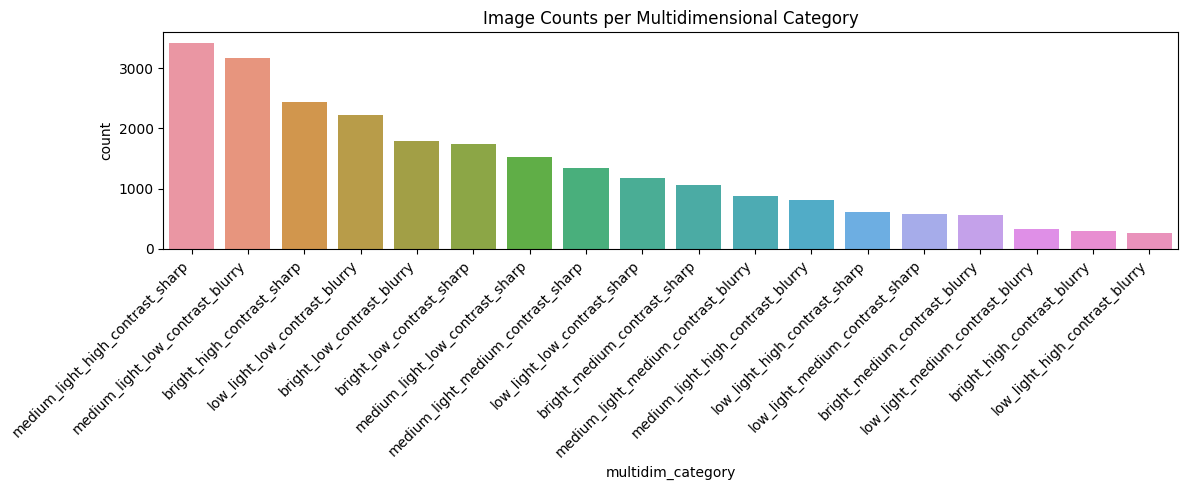

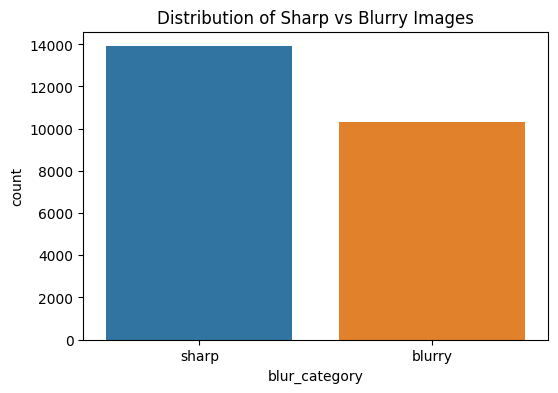

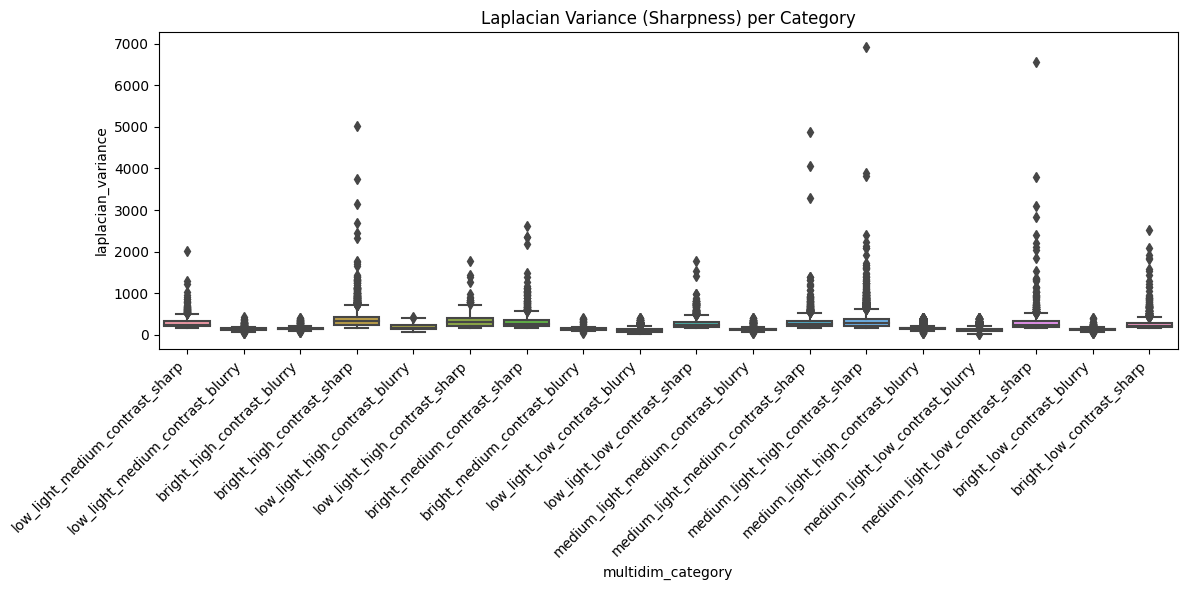

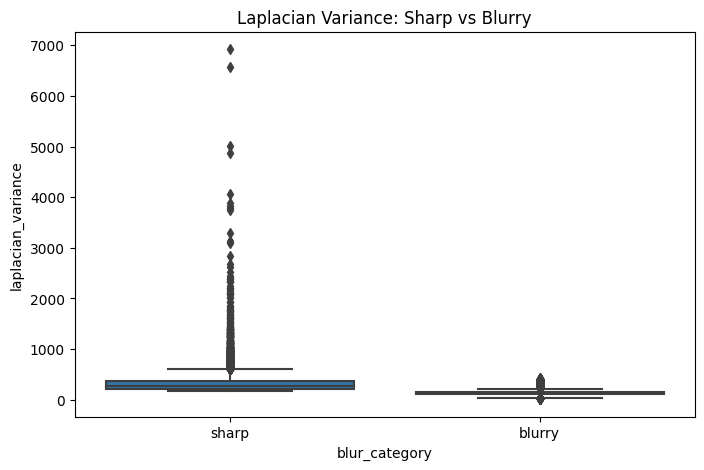


🔍 Summary Statistics:

                      multidim_category blur_category  count        mean  \
0           bright_high_contrast_blurry        blurry    288  162.822467   
1            bright_high_contrast_sharp         sharp   2447  380.426362   
2            bright_low_contrast_blurry        blurry   1788  138.001882   
3             bright_low_contrast_sharp         sharp   1740  266.520546   
4         bright_medium_contrast_blurry        blurry    560  145.214071   
5          bright_medium_contrast_sharp         sharp   1062  316.461497   
6        low_light_high_contrast_blurry        blurry    260  184.567365   
7         low_light_high_contrast_sharp         sharp    603  345.260381   
8         low_light_low_contrast_blurry        blurry   2229  111.942663   
9          low_light_low_contrast_sharp         sharp   1174  281.927851   
10     low_light_medium_contrast_blurry        blurry    334  149.513830   
11      low_light_medium_contrast_sharp         sharp    586  29

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load all data
df1 = pd.read_csv('/kaggle/working/multidimensional_classification_results1.csv')
df2 = pd.read_csv('/kaggle/working/multidimensional_classification_results2.csv')
df3 = pd.read_csv('/kaggle/working/multidimensional_classification_results3.csv')

# Combine them
df_all = pd.concat([df1, df2, df3], ignore_index=True)

# -------------------------
# 1. Category distributions
# -------------------------
plt.figure(figsize=(12, 5))
sns.countplot(data=df_all, x='multidim_category', order=df_all['multidim_category'].value_counts().index)
plt.title("Image Counts per Multidimensional Category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# -------------------------------------
# 2. Blur category distribution overall
# -------------------------------------
plt.figure(figsize=(6, 4))
sns.countplot(data=df_all, x='blur_category')
plt.title("Distribution of Sharp vs Blurry Images")
plt.show()

# ------------------------------------------
# 3. Mean Laplacian Variance by Category
# ------------------------------------------
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_all, x='multidim_category', y='laplacian_variance')
plt.title("Laplacian Variance (Sharpness) per Category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 4. Laplacian Variance: Sharp vs Blurry Comparison
# --------------------------------------------------
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_all, x='blur_category', y='laplacian_variance')
plt.title("Laplacian Variance: Sharp vs Blurry")
plt.show()

# ------------------------------------------
# 5. Summary Statistics (per-category stats)
# ------------------------------------------
summary_stats = df_all.groupby(['multidim_category', 'blur_category'])['laplacian_variance'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()
print("\n🔍 Summary Statistics:\n")
print(summary_stats)

# Save summary to CSV
summary_stats.to_csv('/kaggle/working/laplacian_summary_by_category.csv', index=False)
